# A simple but slow unstructured mesh program

Spark's graph-parallel package, [GraphX](http://spark.apache.org/graphx/), enables very efficient computations on graphs like unstructured meshes.

Unfortunately some of the coolest features won't be accessible through python until Spark 2.x, but we can give an idea how it works now, quite slowly, using RDDs:

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import findspark

findspark.init()
from pyspark import SparkContext

In [2]:
sc = SparkContext("local")

We will need global information about our mesh here, and in Spark that means "broadcast variables" (think global constants across processes).  We'll make a tuple a global constant and define some functions as easy ways to get at them:

In [3]:
# Routines for broadcasting a geometry as a tuple and getting facts back about it.

npts_x = 11
npts_y = 11
npts = npts_x * npts_y
dx_val = 1./(npts_x-1)
dy_val = 1./(npts_y-1)

mesh = [npts_x, npts_y, npts, dx_val, dy_val]

mesh = sc.broadcast(mesh)

def npts():
    return mesh.value[2]

def npts_x():
    return mesh.value[0]

def npts_y():
    return mesh.value[1]

def dx():
    return mesh.value[3]

def dy():
    return mesh.value[4]

We'll have a 1-d list of points, indiciated by indicies, and below are some routines to look up the point positions and the neighbours by indicies.  Note that what we have below actually sets up a structured (if irregular) triangular mesh, but nothing below assumes anything about the structure of the mesh (even that it's static).

In [4]:
# Routines setting up an (actually structured) triangle connectivity

def idx_to_grid(idx):
    return (idx % npts_x(), idx//npts_x())

def grid_to_idx(i, j):
    return j*npts_x()+i

def valid_point(i, j):
    return i>= 0 and i < npts_x() and j >= 0 and j < npts_y()

def interior_point(i,j):
    return i> 0 and i < npts_x()-1 and j > 0 and j < npts_y()-1

def interior_idx(self, idx):
    return interior_point(*idx_to_grid(idx))

def idx_to_x(idx):
    return idx_to_grid(idx)[0]*dx()
 
def idx_to_y(idx):
    return idx_to_grid(idx)[1]*dy()
    
def neighbours_of(idx):
    deltas = [-1, 0, 1]
    i, j = idx_to_grid(idx)
    all_neighs = [(i+di,j+dj) for di in deltas for dj in deltas if not (di == 0 and dj == 0)]
    return [grid_to_idx(*neighbour) for neighbour in all_neighs if valid_point(*neighbour)]

Ok, now we are ready to go.  We'll define an initial condition - a guassian blob of density at a given position and with a given size.  The function below returns that value (along with the x and y positions) at a given index

In [5]:
def initial_conditions(idx, initial_posx=0.3, initial_posy=0.3, sigma=0.15):
    """Returns a tuple describing the state at the point:
        (x, y, density(x,y))"""
    x = idx_to_x(idx) + np.random.rand()/(3*npts_x())
    y = idx_to_y(idx) + np.random.rand()/(3*npts_y())
    density = np.exp(-((x-initial_posx)**2 + (y-initial_posy)**2)/(sigma**2))
    return (x, y, density)

And now we're going to set up the main data structures - split-up RDDs of the values (with an index, and a tuple of (x, y, density), and the edge list - eg, that index 0 is connected to 20 and vice versa.

In [6]:
values = sc.parallelize(range(npts()))\
            .map(lambda idx:(idx, initial_conditions(idx)))
        
neighbours = sc.parallelize(range(npts()))\
                .flatMap(lambda idx:[(idx, neigh) for neigh in neighbours_of(idx)]).persist()

Let's see what we've got now - here's a routine which collects all the data to the main process and graphs it:

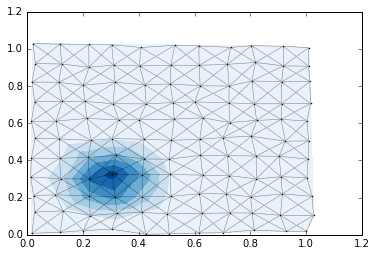

In [7]:
def show_results(field, neighbours):
    allvalues = sorted(values.collect())
    allneighbourpairs = neighbours.collect()

    xs, ys, value = zip(*[values[1] for values in allvalues])
    plt.tricontourf(xs, ys, value, cmap=plt.cm.Blues)
    plt.plot(xs, ys, 'ko', markersize=1)
    
    gridline_xs = [xvalue for idx, nbr in allneighbourpairs
                          for xvalue in (xs[idx], xs[nbr], None)]
    gridline_ys = [yvalue for idx, nbr in allneighbourpairs
                          for yvalue in (ys[idx], ys[nbr], None)]
    plt.plot(gridline_xs, gridline_ys, 'k-', linewidth=.5, alpha=0.25)
    
show_results(values, neighbours)    

Lovely!  Now, we'll set up a simple constant-velocity advection on this field.  To do that, we need some way of calculating the gradient at each point.  (Students, look away - this is a kind of crummy way of solving an advection equation.  I'm not even upwinding!  But this gradient calculation is quite general and would work with moving points. 

In [8]:
def gather_pt_values(vals, neighs):
    """For each point, gather all of the data relevant to that point."""
    #First, generate for each index, a pair-RDD with all the neighbour values (x, y, value)
    # so that we'd have (0, [(x1, y1, v1), (x2,y2,v2)...])
    neighbourvalues = vals.join(neighs)\
                               .map(lambda x:(x[1][1], x[1][0]))\
                               .groupByKey()
    # then add the point values themselves, so you have
    # (0, [(x0, y0, v0), [(x1, y1, v1), (x2, y2, v2)...]])
    return vals.join(neighbourvalues)

def gradient_at_idx(gathered_values):
    """Given all of the values at a given point, calculate the gradient.
       Use an MLS method appropriate for meshless methods"""
    # the values for this point:
    idx = gathered_values[0]
    x_o, y_o, u_o = gathered_values[1][0]
    
    # the values for all neighbour points
    xs, ys, values = zip(*gathered_values[1][1])
    
    # we're going to approximate the field as a biquadratic around the point
    x_xo = np.array(xs) - x_o
    y_yo = np.array(ys) - y_o
    u_uo = np.array(values) - u_o

    # the coefficients of this least squares problem will be the x- and y- derivatives
    # of the interpolating function
    A = np.array([x_xo, y_yo]).T
    grad, _, _, _ = np.linalg.lstsq(A, u_uo)    
    return idx, grad

Now we're mostly ready - we set up the problem.  There's some constant velocity v (which is again a broadcast variable) and to update the values we use simple first-order differences:

In [9]:
v = sc.broadcast(np.array([0.1, 0.1]))
speed = np.sqrt(v.value[0]**2 + v.value[1]**2)
cfl = 0.25

dt = sc.broadcast(cfl*dx()/speed)

def update_values(values):
    idx, value_grad = values
    value, grad = value_grad
    
    newvalue = value[2] - dt.value * np.dot(v.value, grad)
    if newvalue > 1:
        newvalue = 1.
    if newvalue < 0:
        newvalue = 0.
    return idx, (value[0], value[1], newvalue)

nsteps = sc.accumulator(0)

def run_n_steps(values, steps):
    for step in range(steps):
        gradients = gather_pt_values(values, neighbours)\
                        .map(gradient_at_idx)
        values = values.join(gradients)\
                        .map(update_values)
        nsteps.value += 1
        if nsteps.value % 5 == 0:
            print(nsteps.value)
    return values

Let's run!  (slowly)

Note that the `run_n_steps` bit just sets up the computation; it's the showing of results (which collects all the data) which is an action, so starts things in motion.

5


PythonRDD[129] at collect at <ipython-input-7-facd99aa5e23>:2

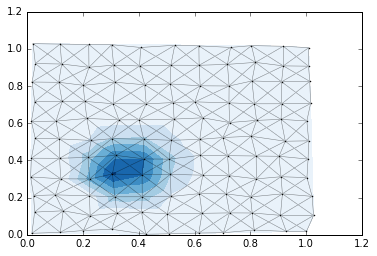

In [10]:
values = run_n_steps(values, 5)
show_results(values, neighbours)
values.persist()

In [ ]:
values = run_n_steps(values, 5)
show_results(values, neighbours)
values.persist()

In [ ]:
values = run_n_steps(values, 5)
show_results(values, neighbours)
values.persist()

In [ ]:
sc.stop()